## get glm coefficients and correlations for publication
Update data in pipeline if needed.

In [1]:
import numpy as np
import pandas as pd
from glob import glob
from subprocess import check_output

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Get data

In [2]:
with open('../forecast_pipeline/pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [3]:
data_fname = glob('../forecast_pipeline/pipeline_data/data_????-??-??.csv')[0]
date = data_fname.split('/')[-1][:-4].split('_')[1]

data_fname_glm_prefix = data_fname.split('/')[-1][:-4] + '_glm'
data_fname_glm_full = 'results/' + data_fname_glm_prefix + '-full.csv'
data_fname_glm_baseline = 'results/' + data_fname_glm_prefix + '-baseline.csv'

In [4]:
df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())

### Covariates

In [5]:
covariates_baseline = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
]
covariates_full = covariates_baseline + ['risk_flu', 'urban_risk']

### standarize

In [6]:
df_z = df[steps_].copy()
for c in covariates_full:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,case0,case1,case2,case3,case4,case5,case6,case7,case8,case9,...,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12.0,7.0,6.0,11.0,9.0,23.0,42.0,45.0,61.0,43.0,...,-0.149053,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,1.006875,0.666999
01003,29.0,37.0,43.0,38.0,34.0,35.0,38.0,19.0,10.0,21.0,...,0.349320,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.296454,0.817850
01005,2.0,7.0,9.0,14.0,11.0,15.0,21.0,26.0,45.0,40.0,...,-0.241908,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.420657,-0.240836
01007,4.0,9.0,13.0,8.0,8.0,3.0,5.0,8.0,14.0,5.0,...,-0.248733,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.436170,-0.249735
01009,10.0,2.0,8.0,11.0,9.0,4.0,1.0,4.0,12.0,9.0,...,-0.143225,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.617627,-0.724261


## Functions

In [7]:
def glm(df, targets, cov, verbose=False):
    
    """
    """
    
    cors_cur, cors_nxt, coef_dfs = [], [], []
    
    for i in range(len(targets)):
        cur = targets[i]
        formula = f'{cur}~{cov}'

        model = smf.glm(
            formula=formula,
            data=df,
            family=sm.families.Poisson(sm.families.links.log())
        ).fit()
        
        if verbose:
            print(f'{model.summary()}\n\n')

        prd = model.predict()
        cor_cur = pd.DataFrame(
            data={'prd': prd, 'grd': df[cur].values}, 
            index=df.index).corr().loc['prd', 'grd']
        cors_cur.append(cor_cur)

        if i < len(targets) - 1:
            nxt = targets[i + 1]
            cor_nxt = pd.DataFrame(
                data={'prd': prd, 'grd': df[nxt].values}, 
                index=df.index).corr().loc['prd', 'grd']
            cors_nxt.append(cor_nxt)

        # Get and save coefficients
        results_as_html = model.summary().tables[1].as_html()
        summary = pd.read_html(results_as_html, header=0, index_col=0)[0] 
        coef_dfs.append(summary[['coef']].rename(columns={'coef': cur}))
    
    cor_df = pd.concat([
        pd.DataFrame(data={'cor_cur': cors_cur}, index=steps),
        pd.DataFrame(data={'cor_nxt': cors_nxt}, index=steps[:-1])
    ], axis=1, join='outer')    
    
    coef_df = pd.concat(coef_dfs, axis=1).rename(columns={t: s for t, s in zip(targets, steps)})
    coef_df.index.name = 'date'
    
    return cor_df, coef_df

# Full GLM

In [8]:
df_full = df_z.copy()
cov_full = '+'.join(covariates_full)

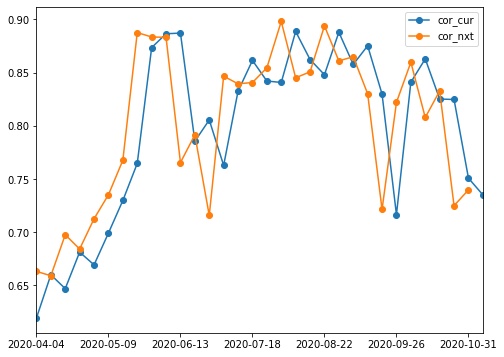

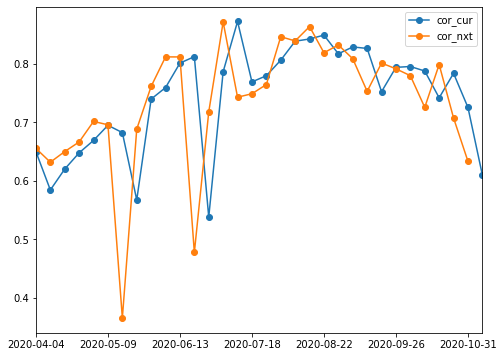

In [9]:
for targets, target_type in zip([steps_c, steps_d], ['case', 'death']):

    cor_df, coef_df = glm(df_full, targets, cov_full)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    cor_df.plot(ax=ax, marker='o')
    ax.legend()

    coef_df.to_csv(f'results/coef_full_{target_type}_{date}.csv', float_format='%.5f')
    cor_df.to_csv(f'results/cor_full_{target_type}_{date}.csv', float_format='%.5f')

df_full.to_csv(data_fname_glm_full, float_format='%.2f')

## Baseline GLM

In [10]:
df_baseline = df_z.copy()
cov_baseline = '+'.join(covariates_baseline)

(3094, 74)


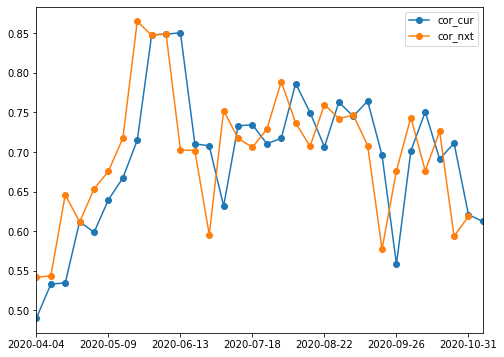

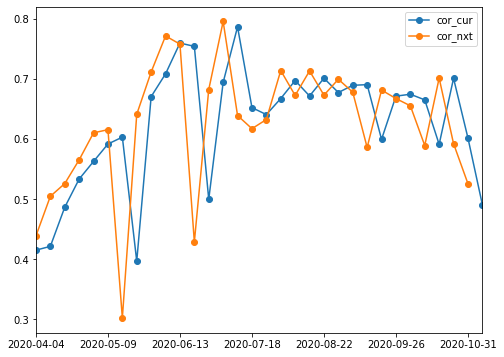

In [11]:
for targets, target_type in zip([steps_c, steps_d], ['case', 'death']):

    cor_df, coef_df = glm(df_full, targets, cov_baseline)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    cor_df.plot(ax=ax, marker='o')
    ax.legend()

    coef_df.to_csv(f'results/coef_baseline_{target_type}_{date}.csv', float_format='%.5f')
    cor_df.to_csv(f'results/cor_baseline_{target_type}_{date}.csv', float_format='%.5f')

df_baseline.to_csv(data_fname_glm_baseline, float_format='%.2f')
print(df_baseline.shape)

# Combine correlation of full and baseline

In [12]:
cor_full_fname = f'results/cor_full_case_{date}.csv'
cor_full = pd.read_csv(cor_full_fname, index_col=0)
cor_full = cor_full.rename(columns={col: col + '_full' for col in cor_full.columns})

cor_baseline_fname = f'results/cor_baseline_case_{date}.csv'
cor_baseline = pd.read_csv(cor_baseline_fname, index_col=0)
cor_baseline = cor_baseline.rename(columns={col: col + '_baseline' for col in cor_baseline.columns})

cor_df = pd.concat([cor_full, cor_baseline], axis=1)
cor_df.index.name = 'date'
cor_df.to_csv(f'results/cor_case_{date}.csv', float_format='%.5f')